In [1]:
%reload_ext autoreload
%autoreload 2
import pynwb
import os

#DataJoint and DataJoint schema
import datajoint as dj
import numpy as np
import pandas as pd

## We also import a bunch of tables so that we can call them easily

from spyglass.common import (RawPosition, HeadDir, Speed, LinPos, StateScriptFile, VideoFile,
                                  DataAcquisitionDevice, CameraDevice, Probe,
                                  DIOEvents,
                                  ElectrodeGroup, Electrode, Raw, SampleCount,
                                  LFPSelection, LFP, LFPBandSelection, LFPBand,
                                  FirFilter,
                                  IntervalList,
                                  Lab, LabMember, LabTeam, Institution,
                                  BrainRegion,
                                  SensorData,
                                  Session, ExperimenterList,
                                  Subject,
                                  Task, TaskEpoch,
                                  Nwbfile, AnalysisNwbfile, NwbfileKachery, AnalysisNwbfileKachery,
                                  get_electrode_indices)
from spyglass.common.common_position import (PositionInfoParameters,IntervalPositionInfo)
from spyglass.common.common_interval import interval_list_intersect



from plot_lfp import (get_x_y_list, get_speed,get_speed_timestamp, get_pos_timestamp,get_timestamps_and_data,get_electrode_ids,remove_dead_tet_chans,check_for_dead_probes,
                      checking_other_dead_tets,simple_plot,plot_overlay,plot_overlay_with_pos,plot_speed_versus_theta, find_overlapping_times,get_x_y_timestamp_list)

import re
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

from spectral_connectivity import Multitaper
from spectral_connectivity import Connectivity
from spectral_connectivity import multitaper_connectivity

from spectral_connectivity.statistics import fisher_z_transform
from spectral_connectivity.statistics import coherence_bias

Connecting emonroe@lmf-db.cin.ucsf.edu:3306


In [2]:
nwb_file_name = 'senor20201030_.nwb'

In [3]:
from spyglass.common.common_position import (IntervalLinearizedPosition, IntervalPositionInfo, TrackGraph)

position_info = (IntervalPositionInfo() &
                 {'nwb_file_name': nwb_file_name,
                  'interval_list_name': 'pos 1 valid times',
                  'position_info_param_name': 'default'}
                ).fetch1_dataframe()
position_info

linear_position_df= (IntervalLinearizedPosition() &
                     {'position_info_param_name': 'default',
                      'nwb_file_name': nwb_file_name,
                      'interval_list_name': 'pos 1 valid times',
                      'track_graph_name': 'senor20201030',
                      'linearization_param_name': 'default',
                     }).fetch1_dataframe()
linear_position_df

linear_position  track_segment_id  projected_x_position  \
time                                                                    
1.604078e+09              NaN                 0                   NaN   
1.604078e+09              NaN                 0                   NaN   
1.604078e+09              NaN                 0                   NaN   
1.604078e+09              NaN                 0                   NaN   
1.604078e+09              NaN                 0                   NaN   
...                       ...               ...                   ...   
1.604079e+09       577.874670                 5             94.909394   
1.604079e+09       575.946687                 5             94.864057   
1.604079e+09       573.968992                 5             94.817551   
1.604079e+09       572.154269                 5             94.774877   
1.604079e+09       570.757364                 5             94.742029   

              projected_y_position  
time                                
1.604078e+09                   NaN  
1.604078e+09                   NaN  
1.604078e+09                   NaN  
1.604078e+09                   NaN  
1.604078e+09                   NaN  
...                            ...  
1.604079e+09             68.395049  
1.604079e+09             70.322499  
1.604079e+09             72.299647  
1.604079e+09             74.113868  
1.604079e+09             75.510387  

[35951 rows x 4 columns]

In [4]:
linear_position_df.iloc[0:10]
linear_position_df['track_segment_id_switch'] = linear_position_df['track_segment_id'].ne(linear_position_df['track_segment_id'].shift())

In [286]:
# for ix in range(len(linear_position_df)):
#     if linear_position_df.iloc[ix].track_id_segment_switch==True

In [6]:
tracking_rows=[]
for ix in range(len(linear_position_df)):
    if linear_position_df.iloc[ix].track_segment_id_switch==True:
        if ix>=1:
            if linear_position_df.iloc[ix-1].track_segment_id ==6:
                tracking_rows.append(ix)
            if linear_position_df.iloc[ix-1].track_segment_id ==7:
                tracking_rows.append(ix)
            if linear_position_df.iloc[ix-1].track_segment_id ==8:
                tracking_rows.append(ix)
        if linear_position_df.iloc[ix].track_segment_id ==6:
            tracking_rows.append(ix)
        if linear_position_df.iloc[ix].track_segment_id ==7:
            tracking_rows.append(ix)
        if linear_position_df.iloc[ix].track_segment_id ==8:
            tracking_rows.append(ix) 
            
            

            


In [ ]:
#first i have to take out times where he switches from a stem (ix-1 = 6,7,8,9)
#then take out thems where he switches into a stem. 


In [7]:
len(tracking_rows)

114

In [8]:
minus_switch_trials =linear_position_df.drop(linear_position_df.index[tracking_rows])

In [9]:
stay_trial_times = minus_switch_trials[minus_switch_trials.track_segment_id_switch==True]

In [10]:
stay_trial_times

linear_position  track_segment_id  projected_x_position  \
time                                                                    
1.604078e+09              NaN                 0                   NaN   
1.604078e+09       186.362136                 1            228.085172   
1.604078e+09       274.711369                 2            139.195255   
1.604078e+09        70.694999                 0            187.968708   
1.604078e+09       140.632908                 1            190.483395   
...                       ...               ...                   ...   
1.604079e+09       546.358726                 5             94.168289   
1.604079e+09       476.652766                 4             92.593767   
1.604079e+09       545.638869                 5             94.151361   
1.604079e+09       477.954567                 4             91.451656   
1.604079e+09       546.631185                 5             94.174695   

              projected_y_position  track_segment_id_switch  
time                                                         
1.604078e+09                   NaN                     True  
1.604078e+09            131.945197                     True  
1.604078e+09            185.364854                     True  
1.604078e+09            103.497041                     True  
1.604078e+09            105.920812                     True  
...                            ...                      ...  
1.604079e+09             99.902278                     True  
1.604079e+09            103.883516                     True  
1.604079e+09            100.621936                     True  
1.604079e+09            104.508230                     True  
1.604079e+09             99.629895                     True  

[160 rows x 5 columns]

Text(0.5, 1.0, 'position during trials I am using for coherence calculations\n n_trials = 160')

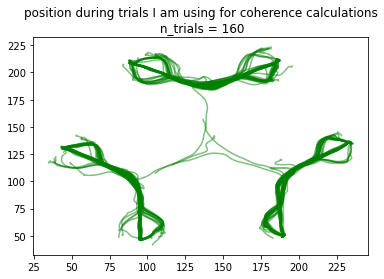

In [11]:
times = stay_trial_times.index
for ix in range(0,len(times)): 
    time_start = times[ix]-1.5
    time_end = times[ix]+1.5
    x_pos,y_pos = get_pos_timestamp(time_start,time_end,position_info)
    plt.plot(x_pos,y_pos, color= 'g',alpha=.5)
plt.title(f'position during trials I am using for coherence calculations\n n_trials = {len(times)}')

In [12]:
#this will label trials where he is ABOUT to stem switch. the trial before stem switch, stem switch=true. 
filename = r'/home/emonroe/Downloads/senor20201030_-Copy1.nwb_TrialsInfoByEpoch.ByTrial.csv'
trial_data = pd.read_csv(filename)
trial_data
trial_data_sesh = trial_data[trial_data.epoch==2]

trial_data_sesh['stem_switch'] = trial_data_sesh['stem'].ne(trial_data_sesh['stem'].shift())

for ix in range(len(trial_data_sesh)):
    if trial_data_sesh.loc[ix,'trial_number_by_epoch']==0:
        trial_data_sesh.loc[ix,'stem_switch']= True
trial_data_sesh['stem_switch']=trial_data_sesh['stem_switch'].shift(-1)        
trial_data_sesh

nwb_file_name  epoch  trial_number_by_epoch  leaf stem  reward  \
0    senor20201030_.nwb      2                      0     4    B       0   
1    senor20201030_.nwb      2                      1     3    B       0   
2    senor20201030_.nwb      2                      2     2    A       0   
3    senor20201030_.nwb      2                      3     1    A       1   
4    senor20201030_.nwb      2                      4     2    A       1   
..                  ...    ...                    ...   ...  ...     ...   
175  senor20201030_.nwb      2                    175     6    C       0   
176  senor20201030_.nwb      2                    176     5    C       1   
177  senor20201030_.nwb      2                    177     6    C       1   
178  senor20201030_.nwb      2                    178     5    C       1   
179  senor20201030_.nwb      2                    179     6    C       0   

       poke_in_ts  reward_on_ts  reward_off_ts   poke_out_ts  ...  \
0    1.604078e+09           NaN            NaN  1.604078e+09  ...   
1    1.604078e+09           NaN            NaN  1.604078e+09  ...   
2    1.604078e+09           NaN            NaN  1.604078e+09  ...   
3    1.604078e+09  1.604078e+09   1.604078e+09  1.604078e+09  ...   
4    1.604078e+09  1.604078e+09   1.604078e+09  1.604078e+09  ...   
..            ...           ...            ...           ...  ...   
175  1.604079e+09           NaN            NaN  1.604079e+09  ...   
176  1.604079e+09  1.604079e+09   1.604079e+09  1.604079e+09  ...   
177  1.604079e+09  1.604079e+09   1.604079e+09  1.604079e+09  ...   
178  1.604079e+09  1.604079e+09   1.604079e+09  1.604079e+09  ...   
179  1.604079e+09           NaN            NaN  1.604079e+09  ...   

     p_rew_leaf5  p_rew_leaf6  decay_percent  p_rew_reset_leaf1  \
0             20           80            NaN                NaN   
1             20           80            NaN                NaN   
2             20           80            NaN                NaN   
3             20           80            NaN                NaN   
4             20           80            NaN                NaN   
..           ...          ...            ...                ...   
175           80           50            NaN                NaN   
176           80           50            NaN                NaN   
177           80           50            NaN                NaN   
178           80           50            NaN                NaN   
179           80           50            NaN                NaN   

     p_rew_reset_leaf2  p_rew_reset_leaf3  p_rew_reset_leaf4  \
0                  NaN                NaN                NaN   
1                  NaN                NaN                NaN   
2                  NaN                NaN                NaN   
3                  NaN                NaN                NaN   
4                  NaN                NaN                NaN   
..                 ...                ...                ...   
175                NaN                NaN                NaN   
176                NaN                NaN                NaN   
177                NaN                NaN                NaN   
178                NaN                NaN                NaN   
179                NaN                NaN                NaN   

     p_rew_reset_leaf5  p_rew_reset_leaf6  stem_switch  
0                  NaN                NaN        False  
1                  NaN                NaN         True  
2                  NaN                NaN        False  
3                  NaN                NaN        False  
4                  NaN                NaN        False  
..                 ...                ...          ...  
175                NaN                NaN        False  
176                NaN                NaN        False  
177                NaN                NaN        False  
178                NaN                NaN        False  
179                NaN                NaN          NaN  

[180 rows

In [13]:
lfp_timestamps, lfp_data, lfp_eseries = get_timestamps_and_data(nwb_file_name,data_type = ['lfp'])
# raw_timestamps, raw_data, raw_eseries = get_timestamps_and_data(nwb_file_name,data_type = ['raw'])


theta_timestamps, theta_data, theta_eseries = get_timestamps_and_data(nwb_file_name,filter_type=['Theta 5-11 Hz'],data_type = ['theta'])

In [193]:
raw_eseries

e-series pynwb.ecephys.ElectricalSeries at 0x140704493700864
Fields:
  comments: No comment
  conversion: 1e-06
  data: <HDF5 dataset "data": shape (716115791, 384), type "<i2">
  description: Recording of extracellular voltage
  electrodes: electrodes <class 'hdmf.common.table.DynamicTableRegion'>
  interval: 1
  resolution: -1.0
  timestamps: <HDF5 dataset "timestamps": shape (716115791,), type "<f8">
  timestamps_unit: seconds
  unit: volts

In [14]:
num_secs_to_get = int(trial_data_sesh.iloc[-1].poke_out_ts - trial_data_sesh.iloc[0].poke_in_ts-1)

electrode_id = [8,17,40,132,244,300]
time_from_start = 0 #in seconds
time_interval_s = num_secs_to_get
sampling_rate_lfp = 1000
sampling_rate_raw = 30000


epoch = (IntervalList & {'nwb_file_name':nwb_file_name} & {'interval_list_name':'02_r1'}).fetch1('valid_times')
x_elect_lfp, y_elect_lfp = get_x_y_list(time_from_start, time_interval_s,epoch, electrode_id, lfp_eseries, lfp_timestamps, lfp_data)
x_elect_theta, y_elect_theta = get_x_y_list(time_from_start, time_interval_s,epoch, electrode_id, theta_eseries, theta_timestamps, theta_data)
# x_elect_raw, y_elect_raw= get_x_y_list(time_from_start, time_interval_s,epoch, electrode_id, raw_eseries, raw_timestamps, raw_data)





In [16]:
sampling_rate = sampling_rate_lfp
num_sec = 3.5
n_trials = len(times)
n_signals= 2
n_time_samples = (num_sec*sampling_rate)
signal = np.zeros((int(n_time_samples), n_trials, n_signals))

electrode_ix1 = 0
electrode_ix2 = 4
keeping_track=[]


for ix in range(0,len(times)): 
    time_start = times[ix]-1.5
    time_end = times[ix]+2
    # x_elect_lfp_eg1, y_elect_lfp_eg1 = get_x_y_timestamp_list(time_start, time_end, electrode_id, lfp_eseries, lfp_timestamps, lfp_data)
    x_elect_lfp_eg1, y_elect_lfp_eg1 = get_x_y_timestamp_list(time_start, time_end, electrode_id, lfp_eseries, lfp_timestamps, lfp_data)
    # time = x_elect_lfp_eg1[0]
    if len(y_elect_lfp_eg1[0]) == n_time_samples:
        keeping_track.append(1)
        signal[:,ix,0] = (y_elect_lfp_eg1[electrode_ix1])
        signal[:,ix,1]= (y_elect_lfp_eg1[electrode_ix2])
    # elif len(y_elect_lfp_eg1[0]) == 1999:
    #     y_elect_lfp_eg1[electrode_ix1].append(0)
    #     y_elect_lfp_eg1[electrode_ix2].append(0)

157

In [ ]:
sampling_frequency=1000
time_halfbandwidth_product=1.5
time_window_duration=.5
time_window_step=None



m = Multitaper(signal,
               sampling_frequency=sampling_frequency,
               time_halfbandwidth_product=time_halfbandwidth_product,
               time_window_duration=time_window_duration,
               time_window_step=time_window_step)
               # start_time=time_data[0])
c = Connectivity(fourier_coefficients=m.fft(),
                 frequencies=m.frequencies,
                 time=m.time)
time_grid, freq_grid = np.meshgrid(
    np.append(c.time, c.time[-1]),
    np.append(c.frequencies, m.nyquist_frequency))

plt.figure(figsize=(20,15))
mesh = plt.pcolormesh(time_grid,freq_grid , c.coherence_magnitude()[..., 0, 1].squeeze().T,
                             vmin=0.0, vmax=1.0, cmap='viridis')
plt.ylabel('frequency',fontsize=20)
plt.xlabel('time',fontsize=20)

plt.ylim(0,50)
plt.yticks(fontsize=20)

plt.xticks(fontsize=20)

# plt.xlim(time_data[0],time_data[-1])
plt.title(f'coherence accoss trials\n electrodes {electrode_id[electrode_ix1]} +{electrode_id[electrode_ix2]} \n n trials = {n_trials}\n freq resolution = {m.frequency_resolution}', fontsize=20)
plt.xlim(0,3)

plt.tight_layout()
cb = plt.colorbar(mesh, orientation='horizontal',
                  shrink=.5, aspect=15, pad=0.1, label='Coherence')
# cb = plt.colorbar(mesh, ax.ravel().tolist(), orientation='horizontal',
#                   shrink=.5, aspect=15, pad=0.1, label='Coherence')
cb.outline.set_linewidth(0)
cb.outline.set_linewidth(0)
cb.fontsize=50
print('frequency resolution: {}'.format(m.frequency_resolution))


In [ ]:
m.n_tapers


Text(0, 0.5, 'coherence')

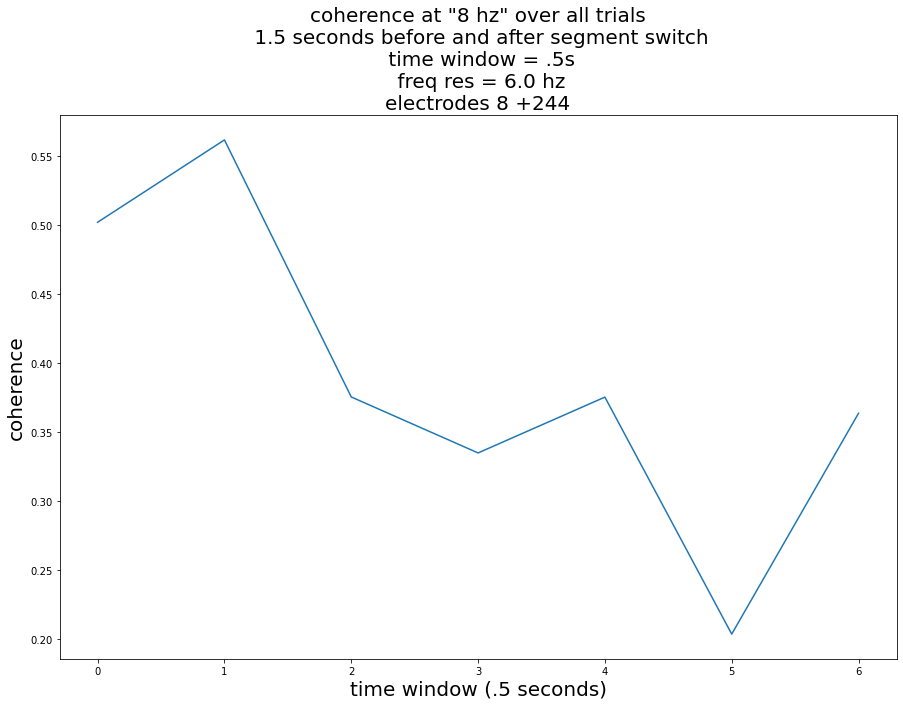

In [188]:
c.frequencies
freq_seg = c.frequencies[(c.frequencies == 8)]# & (c.frequencies <=9.5)]
coh_seg = c.coherence_magnitude()[..., 0, 1].squeeze().T[(c.frequencies == 8)]# & (c.frequencies <=9.5)]
coherency = c.coherency()[:, (c.frequencies == 8), 0, 1].squeeze()
coherency
plt.figure(figsize=(15,10))
plt.plot(coh_seg[0])
plt.title(f'coherence at "8 hz" over all trials\n 1.5 seconds before and after segment switch\n time window = .5s\n freq res = {m.frequency_resolution} hz\nelectrodes {electrode_id[electrode_ix1]} +{electrode_id[electrode_ix2]}',fontsize=20)
plt.xlabel('time window (.5 seconds)',fontsize=20)
plt.ylabel('coherence',fontsize=20)

In [190]:
less_than_100 = c.frequencies[c.frequencies<100]

Text(0, 0.5, 'coherence')

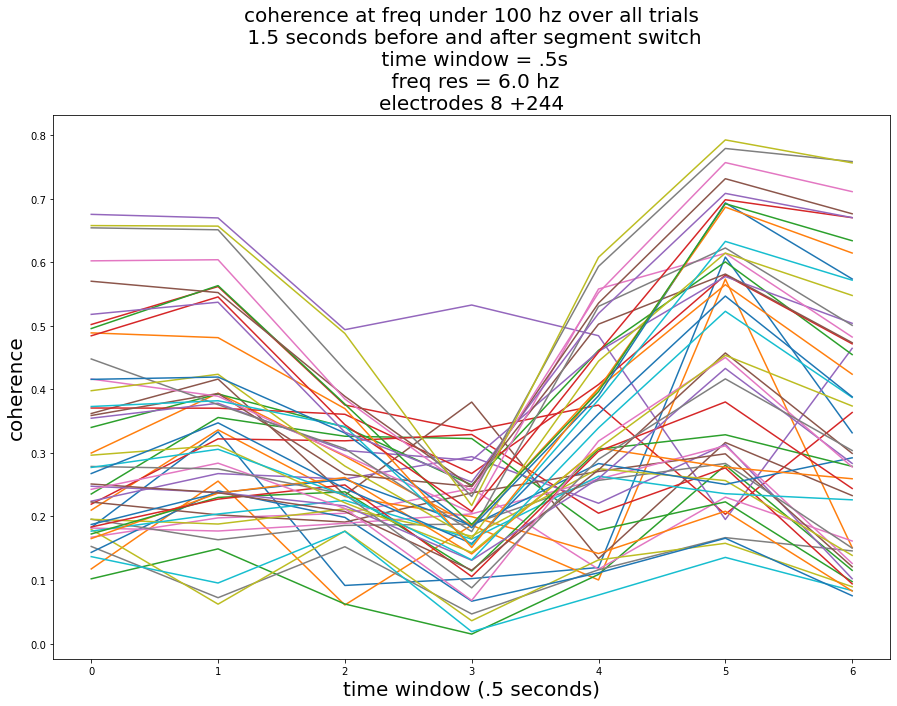

In [191]:
freq = less_than_100 
plt.figure(figsize=(15,10))


for ix in range(1,len(freq)):
    freq_indiv = freq[ix]
    freq_seg = c.frequencies[(c.frequencies == freq_indiv)]# & (c.frequencies <=9.5)]
    coh_seg = c.coherence_magnitude()[..., 0, 1].squeeze().T[(c.frequencies == freq_indiv)]# & (c.frequencies <=9.5)]
    coherency = c.coherency()[:, (c.frequencies == freq_indiv), 0, 1].squeeze()
    plt.plot(coh_seg[0])
plt.title(f'coherence for all freq under 100 hz over all trials\n 1.5 seconds before and after segment switch\n time window = .5s\n freq res = {m.frequency_resolution} hz\nelectrodes {electrode_id[electrode_ix1]} +{electrode_id[electrode_ix2]}',fontsize=20)
plt.xlabel('time window (.5 seconds)',fontsize=20)
plt.ylabel('coherence',fontsize=20)

In [ ]:
f

In [157]:
bias1 = coherence_bias(c.n_observations)

In [158]:
z_transform= fisher_z_transform(coherency, bias1)



Text(0, 0.5, 'z transform')

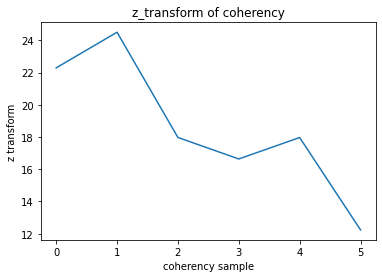

In [159]:
plt.plot(z_transform)
plt.title('z_transform of coherency')
plt.xlabel('coherency sample')
plt.ylabel('z transform')

In [160]:
import math

num_tapers= m.n_tapers
num_trials = m.n_trials

ci_95_pos=[]
ci_95_neg=[]
for ix in range(len(z_transform)):
    z_ixed = z_transform[ix]
    # ci_95_pos.append(z_ixed + 1.96 * math.sqrt(1 / (2 * (num_trials * num_tapers) -2)))
    # ci_95_neg.append(z_ixed - 1.96 * math.sqrt(1 / (2 * (num_trials * num_tapers) -2)))
    ci_95_pos.append(1.96 * math.sqrt(1 / (2 * (num_trials * num_tapers) -2)))
    ci_95_neg.append(-1* 1.96 * math.sqrt(1 / (2 * (num_trials * num_tapers) -2)))



Text(0, 0.5, 'coherence')

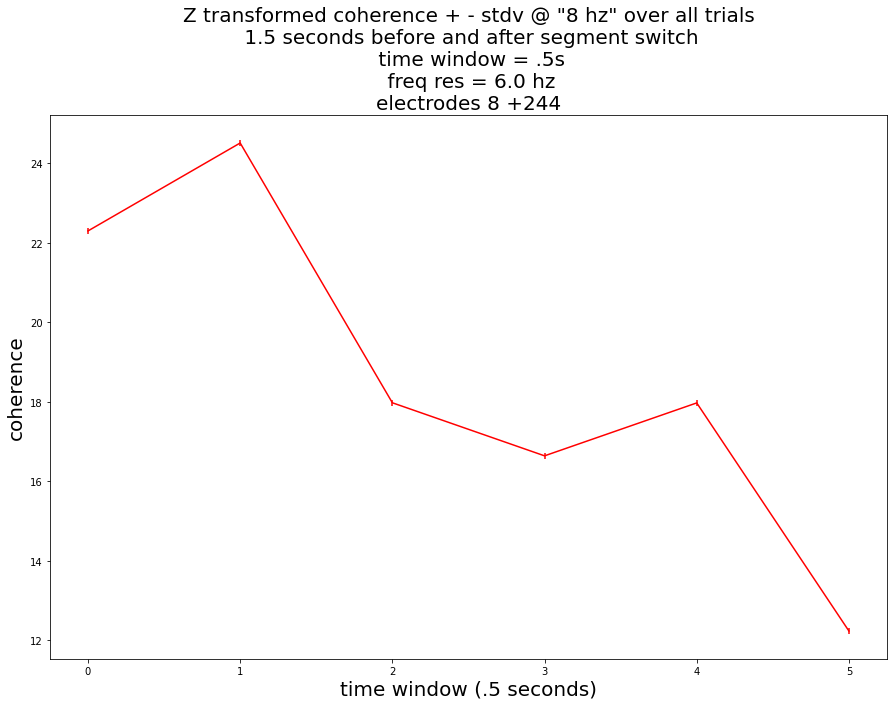

In [168]:
plt.figure(figsize=(15,10))
plt.errorbar(range(len(z_transform)),z_transform,
            yerr=ci_95_pos,
            color = 'r')
plt.title(f'Z transformed coherence + - stdv @ "8 hz" over all trials\n 1.5 seconds before and after segment switch\n time window = .5s\n freq res = {m.frequency_resolution} hz\nelectrodes {electrode_id[electrode_ix1]} +{electrode_id[electrode_ix2]}',fontsize=20)
plt.xlabel('time window (.5 seconds)',fontsize=20)
plt.ylabel('coherence',fontsize=20)

In [167]:
ci_95_pos

[0.0775971430815598,
 0.0775971430815598,
 0.0775971430815598,
 0.0775971430815598,
 0.0775971430815598,
 0.0775971430815598]

In [ ]:

# 1 function that fetches the data, organizes it into arrays/dfs. 
# 2 algorithm itself.. does the computation. 
# move it into .py file. each cell = 1 function. 
#split things into functions as much as possible. 


from scipy import signal as sig


sampling_rate = sampling_rate_lfp
num_sec = 3.5
n_trials = len(times)
n_signals= 2
n_time_samples = (num_sec*sampling_rate)
signal = np.zeros((int(n_time_samples), n_trials, n_signals))

electrode_ix1 = 0
electrode_ix2 = 4
keeping_track=[]


for ix in range(0,len(times)): 
    time_start = times[ix]-1.5
    time_end = times[ix]+2
    # x_elect_lfp_eg1, y_elect_lfp_eg1 = get_x_y_timestamp_list(time_start, time_end, electrode_id, lfp_eseries, lfp_timestamps, lfp_data)
    x_elect_theta_eg1, y_elect_theta_eg1 = get_x_y_timestamp_list(time_start, time_end, electrode_id, theta_eseries, theta_timestamps, theta_data)
    # time = x_elect_lfp_eg1[0]
    if len(y_elect_lfp_eg1[electrode_ix1]) == n_time_samples:
        plt.figure(figsize=(20,1))
        plt.plot(y_elect_theta_eg1[electrode_ix1])
        plt.plot(y_elect_theta_eg1[electrode_ix2])
        plt.figure(figsize=(30,2))
        f, t, Sxx = sig.spectrogram(y_elect_theta_eg1[electrode_ix1], 1000)
        plt.pcolormesh(t, f, Sxx, shading='gouraud')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.title(f'power electrode {electrode_id[electrode_ix1]}')
        plt.colorbar()
        plt.ylim(0,20)
        plt.figure(figsize=(30,2))
        f, t, Sxx = sig.spectrogram(y_elect_theta_eg1[electrode_ix2], 1000)
        plt.pcolormesh(t, f, Sxx, shading='gouraud')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.title(f'power electrode {electrode_id[electrode_ix2]}')
        plt.ylim(0,20)
        plt.colorbar()




        # keeping_track.append(1)
        # signal[:,ix,0] = (y_elect_lfp_eg1[electrode_ix1])
        # signal[:,ix,1]= (y_elect_lfp_eg1[electrode_ix2])
    # elif len(y_elect_lfp_eg1[0]) == 1999:
    #     y_elect_lfp_eg1[electrode_ix1].append(0)
    #     y_elect_lfp_eg1[electrode_ix2].append(0)

In [58]:
counter=[]
counter_many_seg=[]
time_seg = []
for ix in range(0, len(trial_data_sesh)):
    trial_start = trial_data_sesh.iloc[ix-1].poke_out_ts
    trial_end = trial_data_sesh.iloc[ix].poke_in_ts
    in_bet_times = times[(times>= trial_start) & (times <= trial_end)]
    if in_bet_times != None:
        counter.append(1)
        time_seg.append(in_bet_times[0])
    else:
        time_seg.append(0)
        
    if len(in_bet_times)>1:
        counter_many_seg.append(1)
        

In [51]:
len(trial_data_sesh)

180

In [59]:
time_seg

[0,
 1604078259.6768906,
 0,
 1604078279.2767003,
 1604078292.4099002,
 1604078301.8431363,
 1604078310.7763803,
 1604078314.476345,
 0,
 1604078328.8762062,
 1604078334.542803,
 1604078344.7760391,
 1604078356.3092668,
 1604078368.5758092,
 1604078380.1756775,
 1604078383.7423227,
 1604078392.0755634,
 1604078395.0088663,
 1604078403.8754404,
 1604078415.5753336,
 1604078423.2419229,
 1604078426.6085575,
 1604078433.8084772,
 1604078442.7083867,
 1604078450.3749812,
 1604078459.3082368,
 1604078467.1081433,
 1604078470.1747797,
 1604078473.2080834,
 1604078476.1747189,
 0,
 1604078489.1412644,
 1604078498.7744937,
 1604078502.9744592,
 1604078506.1411016,
 1604078508.9410658,
 1604078511.9410276,
 0,
 1604078523.8409228,
 1604078532.6408374,
 1604078537.3407867,
 0,
 1604078556.8072598,
 1604078560.4405515,
 1604078566.0738235,
 1604078569.573782,
 1604078576.9070516,
 1604078581.5403328,
 0,
 1604078596.04019,
 1604078599.5401542,
 0,
 1604078605.57343,
 0,
 1604078620.6399572,
 1604

In [63]:
trial_data_sesh['time_at_intersection'] = time_seg

In [65]:
trial_data_sesh[0:20]

nwb_file_name  epoch  trial_number_by_epoch  leaf stem  reward  \
0   senor20201030_.nwb      2                      0     4    B       0   
1   senor20201030_.nwb      2                      1     3    B       0   
2   senor20201030_.nwb      2                      2     2    A       0   
3   senor20201030_.nwb      2                      3     1    A       1   
4   senor20201030_.nwb      2                      4     2    A       1   
5   senor20201030_.nwb      2                      5     1    A       1   
6   senor20201030_.nwb      2                      6     2    A       0   
7   senor20201030_.nwb      2                      7     1    A       1   
8   senor20201030_.nwb      2                      8     4    B       0   
9   senor20201030_.nwb      2                      9     3    B       0   
10  senor20201030_.nwb      2                     10     5    C       0   
11  senor20201030_.nwb      2                     11     6    C       1   
12  senor20201030_.nwb      2                     12     5    C       1   
13  senor20201030_.nwb      2                     13     1    A       1   
14  senor20201030_.nwb      2                     14     2    A       0   
15  senor20201030_.nwb      2                     15     1    A       1   
16  senor20201030_.nwb      2                     16     2    A       0   
17  senor20201030_.nwb      2                     17     1    A       1   
18  senor20201030_.nwb      2                     18     2    A       1   
19  senor20201030_.nwb      2                     19     1    A       1   

      poke_in_ts  reward_on_ts  reward_off_ts   poke_out_ts  ...  p_rew_leaf6  \
0   1.604078e+09           NaN            NaN  1.604078e+09  ...           80   
1   1.604078e+09           NaN            NaN  1.604078e+09  ...           80   
2   1.604078e+09           NaN            NaN  1.604078e+09  ...           80   
3   1.604078e+09  1.604078e+09   1.604078e+09  1.604078e+09  ...           80   
4   1.604078e+09  1.604078e+09   1.604078e+09  1.604078e+09  ...           80   
5   1.604078e+09  1.604078e+09   1.604078e+09  1.604078e+09  ...           80   
6   1.604078e+09           NaN            NaN  1.604078e+09  ...           80   
7   1.604078e+09  1.604078e+09   1.604078e+09  1.604078e+09  ...           80   
8   1.604078e+09           NaN            NaN  1.604078e+09  ...           80   
9   1.604078e+09           NaN            NaN  1.604078e+09  ...           80   
10  1.604078e+09           NaN            NaN  1.604078e+09  ...           80   
11  1.604078e+09  1.604078e+09   1.604078e+09  1.604078e+09  ...           80   
12  1.604078e+09  1.604078e+09   1.604078e+09  1.604078e+09  ...           80   
13  1.604078e+09  1.604078e+09   1.604078e+09  1.604078e+09  ...           80   
14  1.604078e+09           NaN            NaN  1.604078e+09  ...           80   
15  1.604078e+09  1.604078e+09   1.604078e+09  1.604078e+09  ...           80   
16  1.604078e+09           NaN            NaN  1.604078e+09  ...           80   
17  1.604078e+09  1.604078e+09   1.604078e+09  1.604078e+09  ...           80   
18  1.604078e+09  1.604078e+09   1.604078e+09  1.604078e+09  ...           80   
19  1.604078e+09  1.604078e+09   1.604078e+09  1.604078e+09  ...           80   

    decay_percent  p_rew_reset_leaf1  p_rew_reset_leaf2  p_rew_reset_leaf3  \
0             NaN                NaN                NaN                NaN   
1             NaN                NaN                NaN                NaN   
2             NaN                NaN                NaN                NaN   
3             NaN                NaN                NaN                NaN   
4             NaN                NaN                NaN                NaN   
5             NaN                NaN                NaN                NaN   
6             NaN                NaN                NaN                NaN   
7             NaN                NaN                NaN                NaN   
8             NaN            

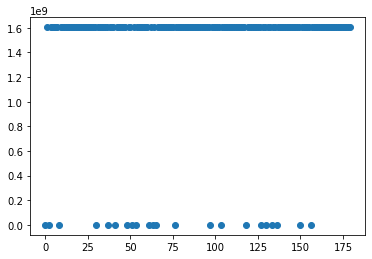

In [355]:
plt.scatter(range(len(trial_data_sesh)),trial_data_sesh.time_at_intersection)

In [48]:
sum(counter)
sum(counter_many_seg)

0

In [ ]:
#This cell will make the spectrogram, and take out only the powers at ~8hz (as determined manually from calculated f) to see the histogram of power in pfc vs hpc

# power_keeping_hpc = []
# power_keeping_pfc = []
# for ix in range(0,len(times)): 
#     time_start = times[ix]-1.5
#     time_end = times[ix]+2
#     x_elect_theta_eg1, y_elect_theta_eg1 = get_x_y_timestamp_list(time_start, time_end, electrode_id, theta_eseries, theta_timestamps, theta_data)
#     if len(y_elect_lfp_eg1[electrode_ix1]) == n_time_samples:
#         f, t, Sxx = sig.spectrogram(y_elect_theta_eg1[electrode_ix1], 1000)
#         power_keeping_hpc.append(Sxx[f == 7.8125][0])
#         f1, t1, Sxx1 = sig.spectrogram(y_elect_theta_eg1[electrode_ix2], 1000)
#         power_keeping_pfc.append(Sxx1[f == 3.90625][0])
#         plt.figure()        
#         plt.hist(Sxx)
#         plt.figure()
#         plt.hist(Sxx1)

In [ ]:

# plt.hist(Sxx1[f == 7.8125][0])
power_keeping_pfc

In [109]:
concat = np.concatenate(power_keeping_pfc[2:])

162.06218


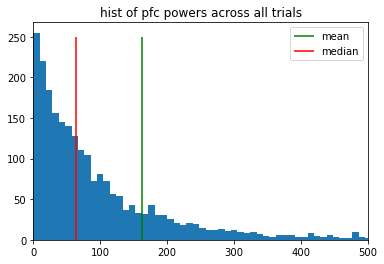

In [344]:
plt.hist(concat,bins=len(concat))
plt.xlim(0,2000)
plt.title('hist of pfc powers across all trials')
plt.vlines(statistics.mean(concat),0,250,color='g',label='mean')
plt.vlines(statistics.median(concat),0,250,color='r',label='median')
plt.legend()
plt.xlim(0,500)
print(statistics.mean(concat))


In [342]:
np.std(concat)

966.02814

(-1.0, 500.0)

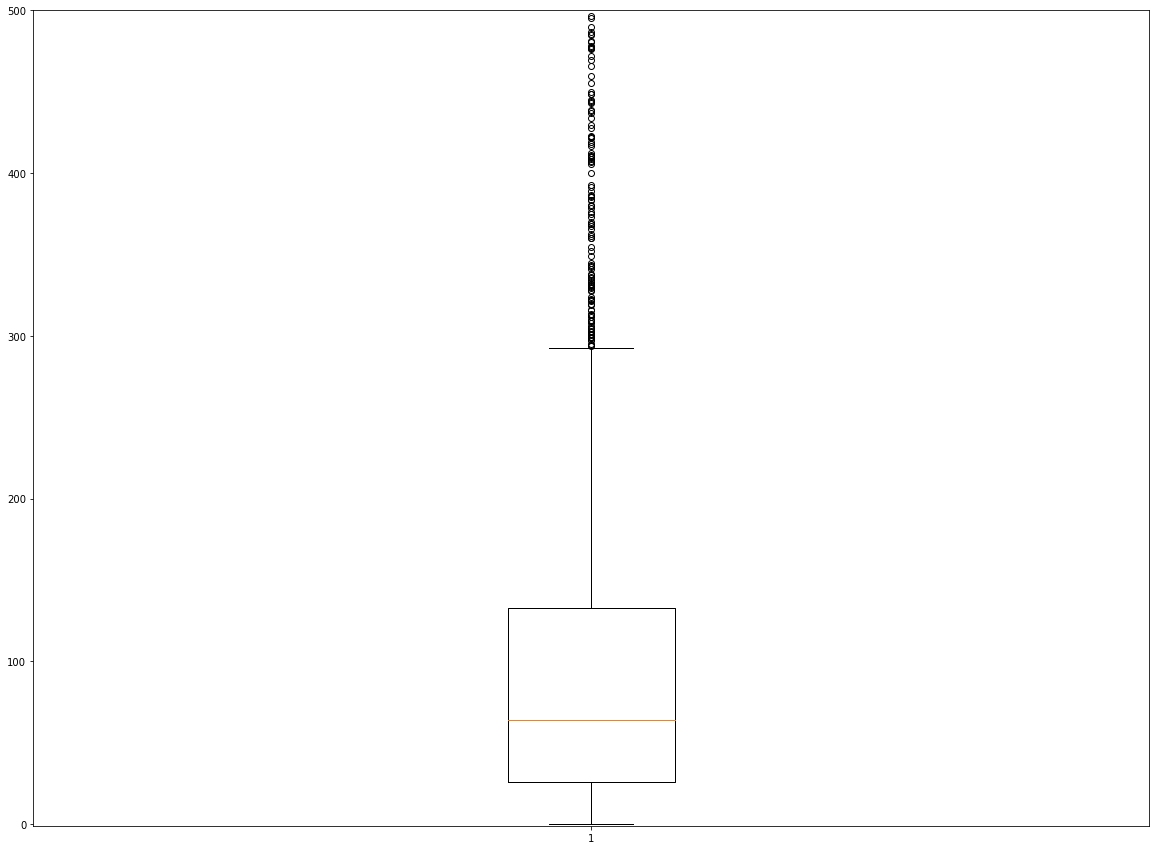

In [251]:
plt.figure(figsize=(20,15))
plt.boxplot(concat)
plt.ylim(-1,500)

In [320]:
#this cell uses "times" to grab trial times from lfp, theta, speed  

# sampling_rate = sampling_rate_lfp
# num_sec = 2.5
# n_trials = len(times)
# n_signals= 2
# n_time_samples = (num_sec*sampling_rate)
# signal = np.zeros((int(n_time_samples), n_trials, n_signals))
# signal_theta = np.zeros((int(n_time_samples), n_trials, n_signals))


# electrode_ix1 = 0
# electrode_ix2 = 4
# keeping_track=[]
# keeping_speed = []

# for ix in range(0,len(times)): 
#     time_start = times[ix]-1.5
#     time_end = times[ix]+1
#     # x_elect_lfp_eg1, y_elect_lfp_eg1 = get_x_y_timestamp_list(time_start, time_end, electrode_id, lfp_eseries, lfp_timestamps, lfp_data)
#     x_elect_theta_eg1, y_elect_theta_eg1 = get_x_y_timestamp_list(time_start, time_end, electrode_id, theta_eseries, theta_timestamps, theta_data)
#     x_elect_lfp_eg1, y_elect_lfp_eg1 = get_x_y_timestamp_list(time_start, time_end, electrode_id, lfp_eseries, lfp_timestamps, lfp_data)
#     x_speed, y_speed = get_speed_timestamp(time_start,time_end,position_info)

#     # time = x_elect_lfp_eg1[0]
#     if len(y_elect_theta_eg1[0]) == n_time_samples:
#         keeping_track.append(1)
#         signal_theta[:,ix,0] = (y_elect_theta_eg1[electrode_ix1])
#         signal_theta[:,ix,1]= (y_elect_theta_eg1[electrode_ix2])
        
#         signal[:,ix,0] = (y_elect_lfp_eg1[electrode_ix1])
#         signal[:,ix,1]= (y_elect_lfp_eg1[electrode_ix2])
#         keeping_speed.append([y_speed])

In [354]:
#this cell uses "time_seg" which are the times related to trial times. need to look back at this.  
sampling_rate = sampling_rate_lfp
num_sec = 2.5
n_trials = len(time_seg)
n_signals= 2
n_time_samples = (num_sec*sampling_rate)
signal = np.zeros((int(n_time_samples), n_trials, n_signals))
signal_theta = np.zeros((int(n_time_samples), n_trials, n_signals))


electrode_ix1 = 0
electrode_ix2 = 4
keeping_track=[]
keeping_speed = []
time_seg1 = pd.Series(time_seg)

for ix in range(0,len(time_seg1)): 
    if time_seg1[ix] != 0:
        time_start =time_seg1[ix]-1.5
        time_end = time_seg1[ix]+1
        # x_elect_lfp_eg1, y_elect_lfp_eg1 = get_x_y_timestamp_list(time_start, time_end, electrode_id, lfp_eseries, lfp_timestamps, lfp_data)
        x_elect_theta_eg1, y_elect_theta_eg1 = get_x_y_timestamp_list(time_start, time_end, electrode_id, theta_eseries, theta_timestamps, theta_data)
        x_elect_lfp_eg1, y_elect_lfp_eg1 = get_x_y_timestamp_list(time_start, time_end, electrode_id, lfp_eseries, lfp_timestamps, lfp_data)
        x_speed, y_speed = get_speed_timestamp(time_start,time_end,position_info)

        # time = x_elect_lfp_eg1[0]
        if len(y_elect_theta_eg1[0]) == n_time_samples:
            keeping_track.append(1)
            signal_theta[:,ix,0] = (y_elect_theta_eg1[electrode_ix1])
            signal_theta[:,ix,1]= (y_elect_theta_eg1[electrode_ix2])

            signal[:,ix,0] = (y_elect_lfp_eg1[electrode_ix1])
            signal[:,ix,1]= (y_elect_lfp_eg1[electrode_ix2])
            keeping_speed.append([y_speed])

In [352]:
type(time_seg)

list

In [349]:
theta_timestamps> time_seg[1]

array([False, False, False, ...,  True,  True,  True])

In [357]:
print(signal.shape)
print(sum(keeping_track))
print(len(keeping_speed))

(2500, 180, 2)
157
157


In [ ]:
electrode_ix1 = 0
electrode_ix2 = 4
n_trials = 1
n_signals = 2
coher_keeper = []
for ix in range(2, len(signal[1,:])):
    if ix not in trial_tracker:
        #get signal, single trial worth of data
        signal_trial = np.zeros((int(n_time_samples), n_trials, n_signals))
        sig_trial_hpc =  signal[:,ix,0]
        sig_trial_pfc =  signal[:,ix,1]
        #get trial for theta band to plot lfp
        signal_trial_theta = np.zeros((int(n_time_samples), n_trials, n_signals))
        sig_trial_hpc_theta =  signal_theta[:,ix,0]
        sig_trial_pfc_theta =  signal_theta[:,ix,1]
        #make a new signal structure to pass into multitaper, just the two trials 
        n_time_samples = len(sig_trial_hpc)
        signal_trial[:,0,0]=sig_trial_hpc 
        signal_trial[:,0,1]=sig_trial_pfc 


        fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(40,20))
        #plot theta band
        plt.figure(figsize = (20,1))
        axes[0].plot(sig_trial_hpc_theta)
        axes[0].plot(sig_trial_pfc_theta)
        axes[0].set_ylabel('amplitude (AD units)',fontsize=20)
        axes[0].set_title('theta filtered lfp- hpc vs pfc',fontsize=20)
        axes[0].tick_params(axis='both', which='major', labelsize=20)
        axes[0].tick_params(axis='both', which='minor', labelsize=20)

        # do the multiptaper/conenctivity 
        sampling_frequency=1000
        time_halfbandwidth_product=1.5
        time_window_duration=.5
        time_window_step=None



        m = Multitaper(sig_trial_hpc,
                       sampling_frequency=sampling_frequency,
                       time_halfbandwidth_product=time_halfbandwidth_product,
                       time_window_duration=time_window_duration,
                       time_window_step=time_window_step)
                       # start_time=time_data[0])
        c = Connectivity(fourier_coefficients=m.fft(),
                         frequencies=m.frequencies,
                         time=m.time)

        mesh = axes[1].pcolormesh(c.time, c.frequencies, c.power().squeeze().T,
                                    cmap='viridis')
        cb = fig.colorbar(mesh, orientation='horizontal',
                          shrink=.5, aspect=15, pad=0.1, label='Power')
        cb.outline.set_linewidth(0)
        axes[1].set_ylim(0,20)
        axes[1].set_ylabel('Frequency [Hz]',fontsize=20)
        axes[1].set_xlabel('Time [sec]',fontsize=20)
        axes[1].set_title(f'power electrode {electrode_id[electrode_ix1]}- hpc',fontsize=20)
        axes[1].tick_params(axis='both', which='major', labelsize=20)
        axes[1].tick_params(axis='both', which='minor', labelsize=20)
        
        power_8hz=  c.power().squeeze().T[(c.frequencies == 8)][0]
        axes[2].plot(power_8hz)
        axes[2].set_ylabel('power',fontsize=20)
        axes[2].set_xlabel('Time [sec]',fontsize=20)
        axes[2].set_title(f'power electrode {electrode_id[electrode_ix1]}-hpc- 8hz',fontsize=20)
        axes[2].tick_params(axis='both', which='major', labelsize=20)
        axes[2].tick_params(axis='both', which='minor', labelsize=20)

        m = Multitaper(sig_trial_pfc,
                       sampling_frequency=sampling_frequency,
                       time_halfbandwidth_product=time_halfbandwidth_product,
                       time_window_duration=time_window_duration,
                       time_window_step=time_window_step)
                       # start_time=time_data[0])
        c = Connectivity(fourier_coefficients=m.fft(),
                         frequencies=m.frequencies,
                         time=m.time)

        mesh = axes[3].pcolormesh(c.time, c.frequencies, c.power().squeeze().T,
                                    cmap='viridis')
        cb = fig.colorbar(mesh, orientation='horizontal',
                          shrink=.5, aspect=15, pad=0.1, label='Power')
        cb.outline.set_linewidth(0)
        axes[3].set_ylim(0,20)
        axes[3].set_ylabel('Frequency [Hz]',fontsize=20)
        axes[3].set_xlabel('Time [sec]',fontsize=20)
        axes[3].set_title(f'power electrode {electrode_id[electrode_ix1]}- pfc',fontsize=20)
        axes[3].tick_params(axis='both', which='major', labelsize=20)
        axes[3].tick_params(axis='both', which='minor', labelsize=20)
        
        power_8hz=  c.power().squeeze().T[(c.frequencies == 8)][0]
        axes[4].plot(power_8hz)
        axes[4].set_ylabel('power',fontsize=20)
        axes[4].set_xlabel('Time [sec]',fontsize=20)
        axes[4].set_title(f'power electrode {electrode_id[electrode_ix1]}-pfc- 8hz',fontsize=20)
        axes[4].tick_params(axis='both', which='major', labelsize=20)
        axes[4].tick_params(axis='both', which='minor', labelsize=20)



        m = Multitaper(signal_trial,
                       sampling_frequency=sampling_frequency,
                       time_halfbandwidth_product=time_halfbandwidth_product,
                       time_window_duration=time_window_duration,
                       time_window_step=time_window_step)
                       # start_time=time_data[0])
        c = Connectivity(fourier_coefficients=m.fft(),
                         frequencies=m.frequencies,
                         time=m.time)



        freq_seg = c.frequencies[(c.frequencies == 8)]
        coh_seg = c.coherence_magnitude()[..., 0, 1].squeeze().T[(c.frequencies == 8)]
        coher_keeper.append(coh_seg[0])
                                 
        # plt.figure(figsize=(20,1))
        axes[5].plot(coh_seg[0])
        axes[5].set_title('coherence at 8hz',fontsize=20)
        axes[5].set_ylabel('coherence',fontsize=20)
        axes[5].tick_params(axis='both', which='major', labelsize=20)
        axes[5].tick_params(axis='both', which='minor', labelsize=20)
        
        axes[6].plot(keeping_speed[ix-3][0])
        axes[6].set_ylabel('speed (cm/s)',fontsize=20)
        axes[6].tick_params(axis='both', which='major', labelsize=20)
        axes[6].tick_params(axis='both', which='minor', labelsize=20)
        plt.tight_layout()




In [318]:
keeping_speed

NameError: name 'keeping_speed' is not defined

Text(0.5, 1.0, 'coherence on each trial, with trials with low pfc theta power removed')

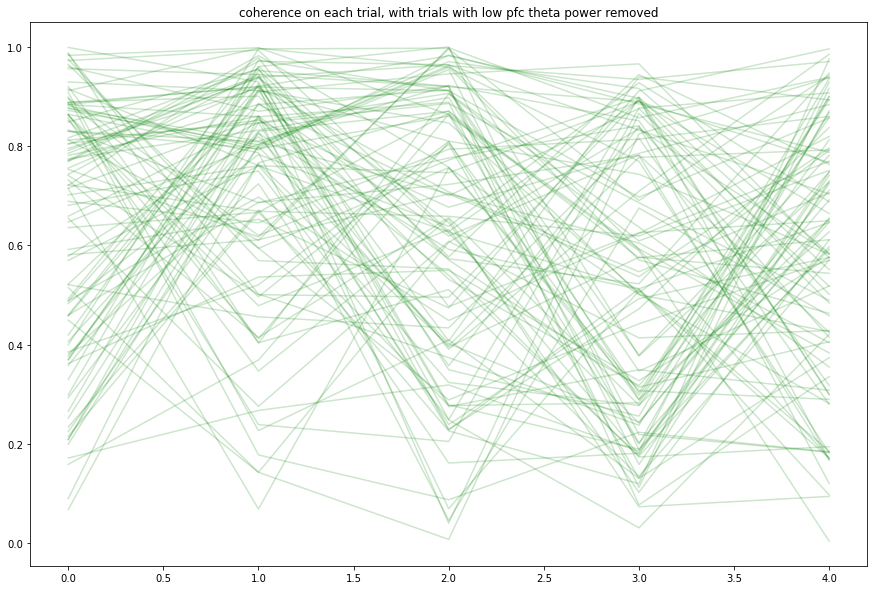

In [361]:
plt.figure(figsize=(15,10))
for ix in range(len(coher_keeper)):
    plt.plot(coher_keeper[ix],color='g',alpha=.2)
a=np.array(coher_keeper)
# x = np.delete(a, (23), axis=0)
plt.plot(np.mean(a, axis=0))
plt.title('coherence on each trial, with trials with low pfc theta power removed')

(0.0, 50.0)

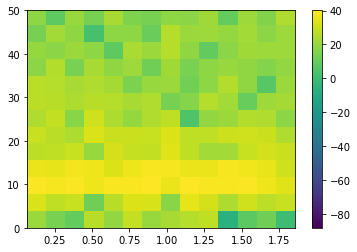

In [230]:
fig, ax1 = plt.subplots()
pxx,  freq, t, cax = ax1.specgram(sig_trial_hpc, Fs = 1000)
fig.colorbar(cax)
ax1.set_ylim(0,50)

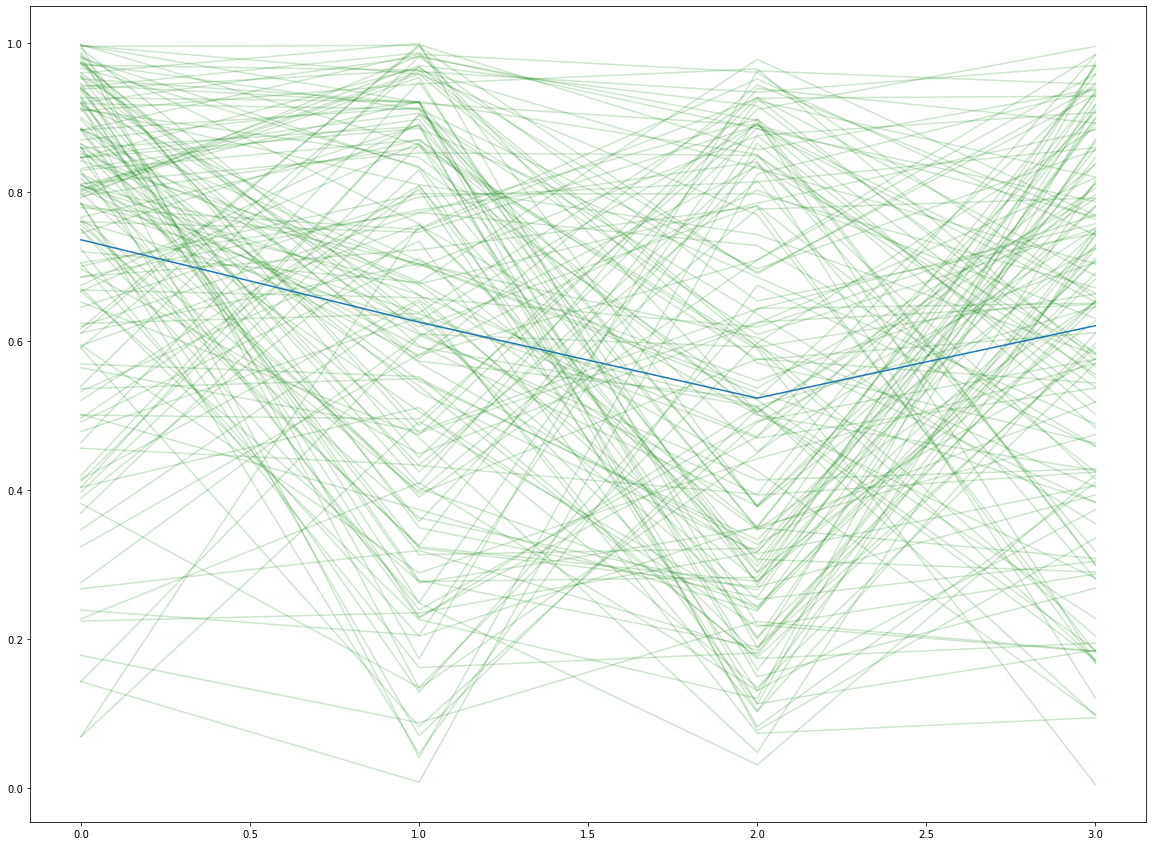

In [207]:
import statistics
electrode_ix1 = 0
electrode_ix2 = 4
n_trials = 1
n_signals = 2
plt.figure(figsize=(20,15))
keeping_coh=[]
for ix in range(2, len(signal[1,:])):
    signal_trial = np.zeros((int(n_time_samples), n_trials, n_signals))
    sig_trial_hpc =  signal[:,ix,0]
    sig_trial_pfc =  signal[:,ix,1]
    
    n_time_samples = len(sig_trial_hpc)
    signal_trial[:,0,0]=sig_trial_hpc 
    signal_trial[:,0,1]=sig_trial_pfc 
    
    sampling_frequency=1000
    time_halfbandwidth_product=1.5
    time_window_duration=.5
    time_window_step=None


    m = Multitaper(signal_trial,
                   sampling_frequency=sampling_frequency,
                   time_halfbandwidth_product=time_halfbandwidth_product,
                   time_window_duration=time_window_duration,
                   time_window_step=time_window_step)
                   # start_time=time_data[0])
    c = Connectivity(fourier_coefficients=m.fft(),
                     frequencies=m.frequencies,
                     time=m.time)
    freq_seg = c.frequencies[(c.frequencies == 8)]# & (c.frequencies <=9.5)]
    coh_seg = c.coherence_magnitude()[..., 0, 1].squeeze().T[(c.frequencies == 8)]# & (c.frequencies <=9.5)]
    # plt.figure(figsize=(20,1))
    plt.plot(coh_seg[0],color='g',alpha=.2)

    keeping_coh.append(coh_seg[0].tolist())

a=np.array(keeping_coh)
x = np.delete(a, (23), axis=0)
plt.plot(np.mean(x, axis=0))



    
    
    
    

In [360]:
import statistics
electrode_ix1 = 0
electrode_ix2 = 4
n_trials = 1
n_signals = 2
trial_tracker=[]

for ix in range(2, len(signal[1,:])):
    signal_trial = np.zeros((int(n_time_samples), n_trials, n_signals))
    sig_trial_hpc =  signal[:,ix,0]
    sig_trial_pfc =  signal[:,ix,1]
    
    # n_time_samples = len(sig_trial_hpc)
    # signal_trial[:,0,0]=sig_trial_hpc 
    # signal_trial[:,0,1]=sig_trial_pfc 
    
    sampling_frequency=1000
    time_halfbandwidth_product=1.5
    time_window_duration=.5
    time_window_step=None


    m = Multitaper(sig_trial_pfc,
                   sampling_frequency=sampling_frequency,
                   time_halfbandwidth_product=time_halfbandwidth_product,
                   time_window_duration=time_window_duration,
                   time_window_step=time_window_step)
                   # start_time=time_data[0])
    c = Connectivity(fourier_coefficients=m.fft(),
                     frequencies=m.frequencies,
                     time=m.time)
    
    power_series_trial = c.power().squeeze().T[(c.frequencies == 8)][0]
    if sum(power_series_trial<75) >round(len(power_series_trial)*.25):
        trial_tracker.append(ix)
    
    # plt.figure()
    # plt.plot(c.time, c.power().squeeze().T[(c.frequencies == 8)][0])
#     fig, axes = plt.subplots(nrows=1, figsize=(15, 9))

#     axes.set_ylim(0,50)
#     mesh = axes.pcolormesh(c.time, c.frequencies, c.power().squeeze().T,
#                                 cmap='viridis')
#     cb = fig.colorbar(mesh, orientation='horizontal',
#                       shrink=.5, aspect=15, pad=0.1, label='Power')
#     cb.outline.set_linewidth(0)

    
    

In [335]:
len(trial_tracker)

36

In [267]:
round(len(power_series_trial)*.25)

2

In [271]:
if sum(power_series_trial<100) >round(len(power_series_trial)*.25):
    trial_tracker.append(ix)

False